# Мобильные приложения — Выделение групп пользователей на основе поведения.


## Описание проекта и общий план.

В мобильном приложении "Ненужные вещи" пользователи продают свои ненужные вещи, размещая их на доске объявлений. Датасет содержит данные о событиях, совершенных в мобильном приложении для пользователей, впервые совершивших действия в приложении после 7 октября 2019 года. По имеющимся данным необходимо выделить группы пользователей, которые различаются по метрикам:
1. retention rate,
2. время, проведённое в приложении,
3. частота действий,
4. конверсия в целевое действие — просмотр контактов.

Также необходимо проверить статистические гипотезы: 

Гипотеза 1: Пользователи, которые установили приложение по ссылке из яндекса и которые установили приложение по ссылке из гугла демонстрируют разную конверсию в просмотры контактов. 

Гипотеза 2: Среднее время, проведенное в приложении для пользователей, которые заходят в приложение в первую половину дня отличается от аналогичного среднего времени для пользователей, которые заходят в приложение во вторую половину дня.


## Описание данных.

В датасете содержатся данные пользователей, впервые совершивших действия в
приложении после 7 октября 2019 года.

Датасет mobile_dataset.csv содержит колонки:

event.time  — время совершения

event.name  — название события

user.id  — идентификатор пользователя

Датасет mobile_sources.csv содержит колонки:

userId  — идентификатор пользователя

source  — источник, с которого пользователь установил приложение

Расшифровки событий:
advert_open  — открытие карточки объявления

photos_show  — просмотр фотографий в объявлении

tips_show  — пользователь увидел рекомендованные объявления

tips_click  — пользователь кликнул по рекомендованному объявлению

contacts_show  и  show_contacts  — пользователь нажал на кнопку "посмотреть номер
телефона" на карточке объявления

contacts_call  — пользователь позвонил по номеру телефона на карточке
объявления

map  — пользователь открыл карту размещенных объявлений

search_1  —  search_7  — разные события, связанные с поиском по сайту

favorites_add  — добавление объявления в избранное

# Шаг 1. Изучение общей информации.


Импортируем все необходимые библиотеки. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
import plotly.express as px
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from statsmodels. stats.weightstats import ztest as ztest

Выведем общую информацию о данных, посмотрим на наличие пропусков, типы данных, названия колонок.

In [2]:
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
mobile_sourсes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [3]:
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Пропусков в данных нет. Все столбцы типа object. Названия колонок приведем к стандартному виду (нижний регистр, нижнее подчеркивание). Заменим тип данных в столбце event.time с object на datetime.

In [4]:
# приводим названия столбцов к стандартному виду.
mobile_dataset = mobile_dataset.rename(columns= {'event.time': 'event_time', 'event.name': 'event_name', 'user.id': 'user_id'})
mobile_sourсes = mobile_sourсes.rename(columns = {'userId': 'user_id'})

In [5]:
mobile_dataset.head(15)

,event_time,event_name,user_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
5,2019-10-07 00:01:19.993624,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
6,2019-10-07 00:01:27.770232,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
7,2019-10-07 00:01:34.804591,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
8,2019-10-07 00:01:49.732803,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
9,2019-10-07 00:01:54.958298,advert_open,020292ab-89bc-4156-9acf-68bc2783f894


In [6]:
mobile_dataset['event_time'].min()

'2019-10-07 00:00:00.431357'

In [7]:
mobile_dataset['event_time'].max()

'2019-11-03 23:58:12.532487'

Данные представлены за период 7 октября 2019 года по 3 ноября 2019 года.

In [8]:
mobile_sourсes.head(15)

,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google
5,17f6b2db-2964-4d11-89d8-7e38d2cb4750,yandex
6,62aa104f-592d-4ccb-8226-2ba0e719ded5,yandex
7,57321726-5d66-4d51-84f4-c797c35dcf2b,google
8,c2cf55c0-95f7-4269-896c-931d14deaab5,google
9,48e614d6-fe03-40f7-bf9e-4c4f61c19f64,yandex


In [9]:
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


Проверим данные на явные и неявные дубликаты.

In [10]:
mobile_dataset.duplicated().sum()

0

In [11]:
mobile_sourсes.duplicated().sum()

0

Явных дубликатов нет. Поищем неявные дубликаты. 

In [12]:
mobile_sourсes['user_id'].nunique()

4293

In [13]:
mobile_sourсes['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

В датасете mobile_sourсes все имена пользователей уникальные, источники, с которых пользователи установили приложение, указаны корректно. Посмотрим, нет ли в датасете mobile_dataset неявных дубликатов в столбце 'event_name'. 

In [14]:
mobile_dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

'contacts_show' и 'show_contacts' обозначают одно событие - пользователь нажал на кнопку "посмотреть номер
телефона" на карточке объявления.


In [15]:
mobile_dataset['event_name'] = mobile_dataset['event_name'].replace("contacts_show", "show_contacts")
mobile_dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'show_contacts', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

Вывод по шагу: пропусков не обнаружено, названия колонок приведены к стандартному виду, явных дубликатов не обнаружено, неявные дубликаты обнаружено в датасете mobile_dataset в столбце event_name ("contacts_show", "show_contacts"). Заменили значения contacts_show на show_contacts. В датасете mobile_dataset столбец event_time приведен к типу данных dataframe, остальные столбцы оставили типа object.

#  Шаг 2. Исследовательский анализ данных.
Исследуем общее поведение пользователей. 

В датасете mobile_dataset у нас имеются данные по каждому действию пользователя, а именно, какое действие совершил пользователь и в какой момент времени было совершено это действие. Для последующего анализа выделим сессии пользователей мобильного приложения. Будем считать, что сессия пользователя закончилась, если между соседними действиями прошло больше 30 минут. 

Для начала нужно провести сортировку по имени пользователя и событию.

In [16]:
mobile_dataset = mobile_dataset.sort_values(['user_id', 'event_time'])
mobile_dataset.head()

,event_time,event_name,user_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349


In [17]:
#convert to datetimes
df = mobile_dataset

#identify difference 30Min for each group with cumulative sum
g = (df.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')).cumsum()
#create counter of groups
df['session_id'] = df.groupby(['user_id', g], sort=False).ngroup() + 1


In [18]:
df['event_date'] = df['event_time'].dt.date
first_day = df.groupby(['user_id'])['event_date'].min()
first_day.name = 'first_day'

df = df.join(first_day, on='user_id')



In [19]:
df.head()

,event_time,event_name,user_id,session_id,event_date,first_day
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07


In [20]:
df.duplicated().sum()

0

Всего получилось 10368 сессий.

Определим следующие метрики:

1.  Retention rate
2. Время, проведенное в приложении
3.  Частота
4.  Конверсия

1. Retention rate

In [21]:
# определим доступный интервал привлечения пользователей
min_analysis_date = df['event_time'].dt.date.min()
observation_date = df['event_time'].dt.date.max()

print(min_analysis_date, observation_date)

# горизонт анализа и максимальная дата привлечения
horizon_days = 10
max_analysis_date = observation_date - timedelta(days=horizon_days - 1)  

print(max_analysis_date)

2019-10-07 2019-11-03
2019-10-25


Всего данные имеются за временной промежуток 7 октября 2019 года - 3 ноября 2019 года. Зададим горизонт анализа 10 дней. Тогда для расчета удержания возьмем данные не позднее чем за 25 октября.

In [22]:
# добавим в датасет информацию об источнике, откуда пользователь сказал приложение.
df_source = df.merge(mobile_sourсes, on='user_id', how='left')
df_source

,event_time,event_name,user_id,session_id,event_date,first_day,source
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other
...,...,...,...,...,...,...,...
74192,2019-11-03 15:51:23.959572,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368,2019-11-03,2019-10-12,google
74193,2019-11-03 15:51:57.899997,show_contacts,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368,2019-11-03,2019-10-12,google
74194,2019-11-03 16:07:40.932077,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368,2019-11-03,2019-10-12,google
74195,2019-11-03 16:08:18.202734,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368,2019-11-03,2019-10-12,google


In [23]:
# рассчитываем лайфтайм
df_source['lifetime'] = (df_source['event_date'] - df_source['first_day']).dt.days

In [24]:
# составляем таблицу удержания
retention_history = df_source.pivot_table(
     index=['first_day', 'source'], columns='lifetime', values='user_id', aggfunc='nunique'
        )
cohort_sizes = df_source.pivot_table(
     index=['first_day', 'source'], values='user_id', aggfunc='nunique'
        ).rename(columns={'user_id': 'cohort_size'})

In [25]:
# ограничиваем данные по горизонту дней = 10
last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
retention = retention_history.query('first_day <= @last_suitable_acquisition_date')

In [26]:
columns_mask = retention.columns < horizon_days 
valid_columns = retention.columns[columns_mask]

retention_valid = retention[valid_columns]

In [27]:
# рассчитываем коэф удержания
for lifetime in retention_valid.columns:
    retention_valid[lifetime] = retention_valid[lifetime] / cohort_sizes['cohort_size']

In [28]:
# пропуски заполняем нулями
retention_valid = retention_valid.fillna(0)

In [29]:
retention_valid

lifetime             0         1         2         3         4         5  \
first_day  source                                                          
2019-10-07 google  1.0  0.178571  0.071429  0.053571  0.053571  0.053571   
           other   1.0  0.155172  0.120690  0.120690  0.000000  0.086207   
           yandex  1.0  0.200000  0.111111  0.133333  0.122222  0.044444   
2019-10-08 google  1.0  0.268293  0.195122  0.121951  0.024390  0.000000   
           other   1.0  0.134615  0.096154  0.134615  0.057692  0.076923   
           yandex  1.0  0.162162  0.094595  0.067568  0.027027  0.027027   
2019-10-09 google  1.0  0.044444  0.022222  0.066667  0.111111  0.088889   
           other   1.0  0.125000  0.083333  0.041667  0.062500  0.125000   
           yandex  1.0  0.108434  0.120482  0.060241  0.024096  0.048193   
2019-10-10 google  1.0  0.114286  0.057143  0.085714  0.028571  0.028571   
           other   1.0  0.137931  0.051724  0.120690  0.086207  0.103448   
           yandex  1.0  0.148148  0.098765  0.098765  0.086420  0.111111   
2019-10-11 google  1.0  0.026316  0.026316  0.078947  0.052632  0.000000   
           other   1.0  0.107143  0.035714  0.214286  0.142857  0.000000   
           yandex  1.0  0.114286  0.128571  0.128571  0.100000  0.128571   
2019-10-12 google  1.0  0.088235  0.088235  0.029412  0.088235  0.088235   
           other   1.0  0.281250  0.156250  0.187500  0.062500  0.062500   
           yandex  1.0  0.220339  0.118644  0.101695  0.050847  0.067797   
2019-10-13 google  1.0  0.200000  0.057143  0.000000  0.028571  0.028571   
           other   1.0  0.093750  0.093750  0.062500  0.000000  0.062500   
           yandex  1.0  0.197531  0.098765  0.074074  0.123457  0.074074   
2019-10-14 google  1.0  0.214286  0.071429  0.119048  0.142857  0.119048   
           other   1.0  0.155172  0.120690  0.086207  0.103448  0.086207   
           yandex  1.0  0.152941  0.082353  0.094118  0.082353  0.035294   
2019-10-15 google  1.0  0.125000  0.062500  0.104167  0.083333  0.041667   
           other   1.0  0.115385  0.096154  0.096154  0.019231  0.019231   
           yandex  1.0  0.186047  0.127907  0.081395  0.069767  0.081395   
2019-10-16 google  1.0  0.196429  0.107143  0.071429  0.017857  0.035714   
           other   1.0  0.129630  0.111111  0.037037  0.018519  0.055556   
           yandex  1.0  0.142857  0.089286  0.053571  0.035714  0.089286   
2019-10-17 google  1.0  0.206897  0.120690  0.172414  0.086207  0.068966   
           other   1.0  0.176471  0.137255  0.137255  0.058824  0.176471   
           yandex  1.0  0.131148  0.081967  0.114754  0.081967  0.065574   
2019-10-18 google  1.0  0.116279  0.139535  0.069767  0.046512  0.023256   
           other   1.0  0.083333  0.055556  0.194444  0.055556  0.027778   
           yandex  1.0  0.103896  0.064935  0.116883  0.077922  0.064935   
2019-10-19 google  1.0  0.200000  0.155556  0.111111  0.044444  0.044444   
           other   1.0  0.088889  0.066667  0.088889  0.000000  0.022222   
           yandex  1.0  0.188406  0.144928  0.057971  0.043478  0.072464   
2019-10-20 google  1.0  0.195122  0.073171  0.073171  0.097561  0.048780   
           other   1.0  0.258065  0.129032  0.096774  0.032258  0.161290   
           yandex  1.0  0.111111  0.069444  0.069444  0.027778  0.055556   
2019-10-21 google  1.0  0.157895  0.026316  0.026316  0.026316  0.052632   
           other   1.0  0.094340  0.207547  0.094340  0.075472  0.075472   
           yandex  1.0  0.114286  0.071429  0.071429  0.085714  0.014286   
2019-10-22 google  1.0  0.155556  0.155556  0.044444  0.066667  0.022222   
           other   1.0  0.170213  0.106383  0.063830  0.085106  0.063830   
           yandex  1.0  0.123077  0.092308  0.076923  0.030769  0.015385   
2019-10-23 google  1.0  0.122807  0.052632  0.070175  0.070175  0.052632   
           other   1.0  0.148936  0.106383  0.148936  0.063830  0.127660   
           yandex  1.0  0.176471  0.082353  0.05

Text(96.0, 0.5, 'День, когда пользователь впервые использовал приложение')

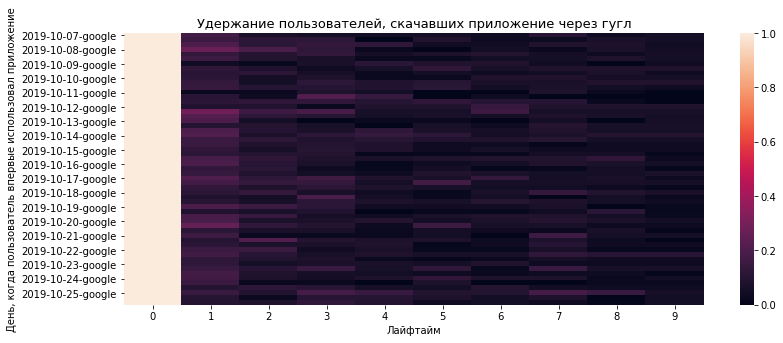

In [30]:
plt.figure(figsize=(13, 5))
plt.title('Удержание пользователей, скачавших приложение через гугл', fontsize=13)
sns.heatmap(retention_valid);
plt.xlabel('Лайфтайм')
plt.ylabel('День, когда пользователь впервые использовал приложение')

Построили тепловую карту. Общая тенденция такова, что удержание пользователей на второй день больше чем в остальные дни, с 3 по 10ые дни удержание колеблется, но в целом к 10му дню уменьшается. Построим графики среднего retention rate по источникам.

In [31]:
data = pd.DataFrame()
i = 0
for first_day, source in retention_valid.index:
    for lifetime in retention_valid.columns:
        data.loc[i, 'first_day'] = first_day
        data.loc[i, 'source'] = source
        data.loc[i, 'lifetime'] = lifetime
        data.loc[i, 'retention'] = retention_valid.loc[(first_day, source), lifetime]
        i += 1

In [32]:
data.head()

,first_day,source,lifetime,retention
0,2019-10-07,google,0.0,1.000000
1,2019-10-07,google,1.0,0.178571
2,2019-10-07,google,2.0,0.071429
3,2019-10-07,google,3.0,0.053571
4,2019-10-07,google,4.0,0.053571


Text(0, 0.5, 'Retention rate')

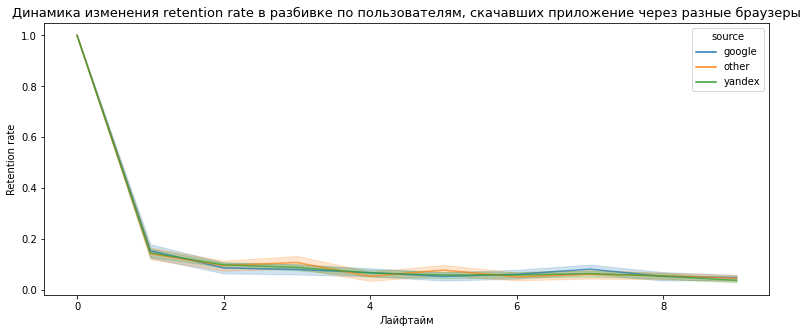

In [33]:
plt.figure(figsize=(13, 5))
plt.title('Динамика изменения retention rate в разбивке по пользователям, скачавших приложение через разные браузеры', fontsize=13)
sns.lineplot(data=data, x='lifetime', y='retention', hue='source', alpha=0.7);
plt.xlabel('Лайфтайм')
plt.ylabel('Retention rate')

График подтверждает предыдущие рассуждения о том, что  на второй день больше чем в остальные дни, с 3 по 10ые дни удержание колеблется, но в целом к 10му дню уменьшается. Также тенденция для разных источников одинакова.

2. Время, проведенное в приложении. 

Мы разбили данные на сессии пользователей. Теперь для каждой сессии вычислим длительность этой сессии и построим распределение, также вычислим среднее и медиану. 

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 805 to 72689
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   session_id  74197 non-null  int64         
 4   event_date  74197 non-null  object        
 5   first_day   74197 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 4.0+ MB


In [35]:
session_dur = (df.groupby('session_id')['event_time'].max() - df.groupby('session_id')['event_time'].min()).reset_index()


In [36]:
session_dur.head()

,session_id,event_time
0,1,0 days 00:09:55.727258
1,2,0 days 00:08:27.385985
2,3,0 days 00:14:59.272096
3,4,0 days 00:12:38.171767
4,5,0 days 00:25:20.787329


In [37]:
session_dur['event_time'].describe()

count                        10368
mean     0 days 00:12:52.672627050
std      0 days 00:19:51.611332472
min                0 days 00:00:00
25%      0 days 00:00:21.137141500
50%      0 days 00:05:35.169711500
75%         0 days 00:17:25.391340
max         0 days 05:21:58.296302
Name: event_time, dtype: object

Медианное время, проведенное пользователями в приложении 5 мин 35 секунд. Среднее время, проведенное пользователями в приложении 12 минут 52 секунды.

In [39]:
session_dur.query('event_time == "0 days 00:00:00"').count()

session_id    2088
event_time    2088
dtype: int64

In [40]:
session_dur['event_time'] = (session_dur['event_time'].astype(int) / 1000000000)

session_dur['event_time']

0         595.727258
1         507.385985
2         899.272096
3         758.171767
4        1520.787329
            ...     
10363       0.000000
10364     974.291817
10365     296.677281
10366     948.307055
10367    1944.381272
Name: event_time, Length: 10368, dtype: float64

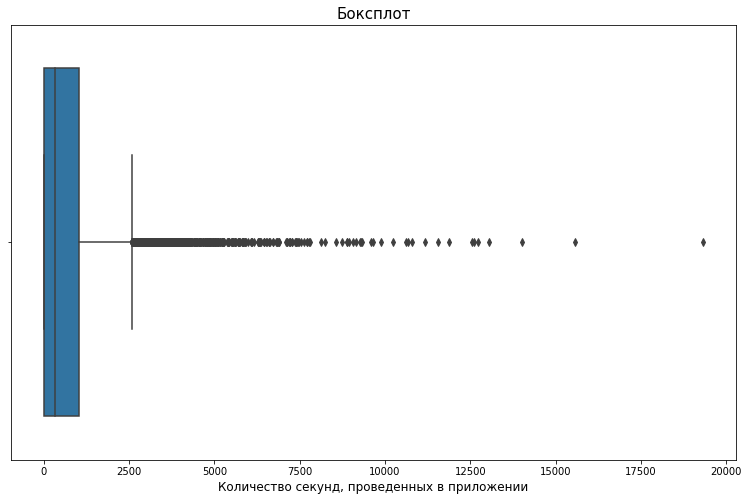

In [41]:
plt.figure(figsize=(13,8))
sns.boxplot(x=session_dur['event_time'])
plt.title('Боксплот', fontsize=15)
plt.xlabel('Количество секунд, проведенных в приложении', fontsize=12)
plt.show()

Из 10368 сессий 2088 сессий являются нулевыми. Рекомендация: попробовать улучшить дизайн карточек объявлений для большего привлечения внимания пользователей.

Среднее время сессии 12 мин 52 секунды, медианное 5 мин 35 секунд, максимальное 5 часов 21 минут 58 секунд. Сессии длительностью больше 2500 секунд - выбросы.

3. Посчитаем частоту. 

Под частотой будем иметь ввиду количество всех событий в разбивке по дням.

In [96]:
freq = df.groupby('event_date')['event_name'].count().reset_index()
freq.describe()

,event_name
count,28.000000
mean,2649.892857
std,408.950358
min,1843.000000
25%,2457.000000
50%,2725.000000
75%,2884.750000
max,3361.000000


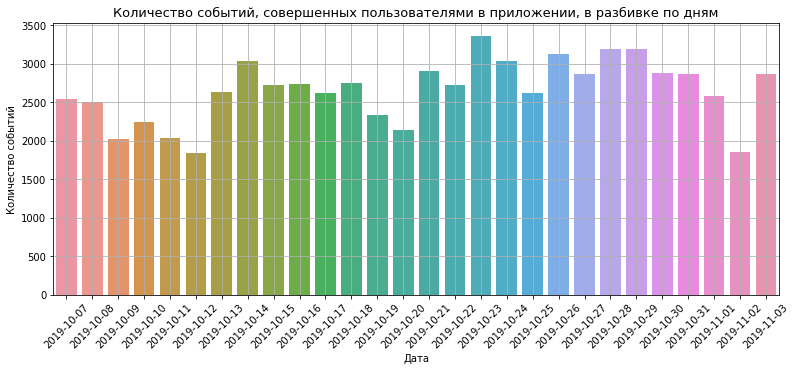

In [43]:
plt.figure(figsize=(13, 5))
plt.title('Количество событий, совершенных пользователями в приложении, в разбивке по дням', fontsize=13)
sns.barplot(x=freq['event_date'], y=freq['event_name'])
plt.xlabel('Дата')
plt.xticks(rotation=45) 
plt.ylabel('Количество событий')
plt.grid(True);

In [44]:
freq['event_name'].median()

2725.0

In [45]:
freq['event_name'].mean()

2649.8928571428573

Среднее количество событий в день 2649, медианное 2725. Наблюдается некоторая цикличность в количестве событий, скорее всего, связанная с днями недели (люди активнее заходят в приложение в будние). 


4. Конверсия. 

Проанализируем конверсию в целевое действие в рамках сессии в разбивке по дням. Затем проделаем то же самое для каждого источника, откуда пользователь скачал приложение, в отдельности. Целевое действие - show_contacts.

In [46]:
df_source

,event_time,event_name,user_id,session_id,event_date,first_day,source,lifetime
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0
...,...,...,...,...,...,...,...,...
74192,2019-11-03 15:51:23.959572,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368,2019-11-03,2019-10-12,google,22
74193,2019-11-03 15:51:57.899997,show_contacts,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368,2019-11-03,2019-10-12,google,22
74194,2019-11-03 16:07:40.932077,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368,2019-11-03,2019-10-12,google,22
74195,2019-11-03 16:08:18.202734,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368,2019-11-03,2019-10-12,google,22


In [47]:
conv_1 = df_source.query('event_name == "show_contacts"').groupby('event_date')['user_id'].nunique()
conv_1

event_date
2019-10-07    34
2019-10-08    36
2019-10-09    41
2019-10-10    44
2019-10-11    34
2019-10-12    27
2019-10-13    34
2019-10-14    50
2019-10-15    57
2019-10-16    41
2019-10-17    62
2019-10-18    66
2019-10-19    45
2019-10-20    54
2019-10-21    57
2019-10-22    68
2019-10-23    68
2019-10-24    63
2019-10-25    60
2019-10-26    51
2019-10-27    47
2019-10-28    59
2019-10-29    54
2019-10-30    58
2019-10-31    62
2019-11-01    63
2019-11-02    50
2019-11-03    59
Name: user_id, dtype: int64

In [48]:
conv = df_source.groupby('event_date')['user_id'].nunique().reset_index()

In [49]:
conv = conv.merge(conv_1, on='event_date', how='left')
conv


,event_date,user_id_x,user_id_y
0,2019-10-07,204,34
1,2019-10-08,204,36
2,2019-10-09,227,41
3,2019-10-10,233,44
4,2019-10-11,206,34
5,2019-10-12,178,27
6,2019-10-13,226,34
7,2019-10-14,298,50
8,2019-10-15,303,57
9,2019-10-16,278,41


In [50]:
conv['conversion, %'] = conv['user_id_y'] / conv['user_id_x'] *100

conv['conversion, %'] = conv['conversion, %'].round(2)
conv

,event_date,user_id_x,user_id_y,"conversion, %"
0,2019-10-07,204,34,16.67
1,2019-10-08,204,36,17.65
2,2019-10-09,227,41,18.06
3,2019-10-10,233,44,18.88
4,2019-10-11,206,34,16.50
5,2019-10-12,178,27,15.17
6,2019-10-13,226,34,15.04
7,2019-10-14,298,50,16.78
8,2019-10-15,303,57,18.81
9,2019-10-16,278,41,14.75


In [51]:
conv['conversion, %'].median()

18.295

In [52]:
conv['conversion, %'].mean()

18.353214285714284

In [53]:
print(conv['conversion, %'].min())
print(conv['conversion, %'].max())

14.75
22.58


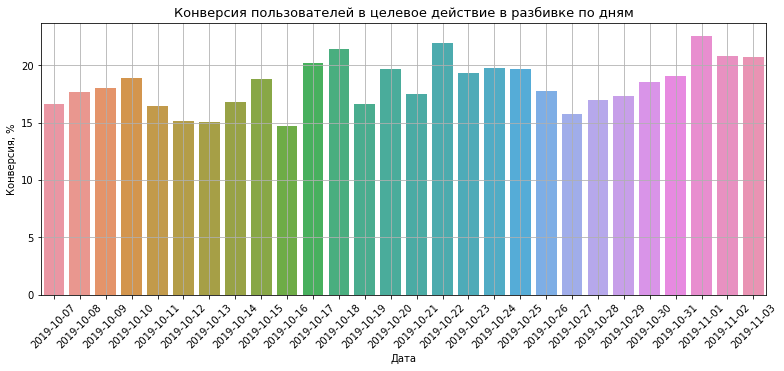

In [54]:
plt.figure(figsize=(13, 5))
plt.title('Конверсия пользователей в целевое действие в разбивке по дням', fontsize=13)
sns.barplot(x=conv['event_date'], y=conv['conversion, %'])
plt.xlabel('Дата')
plt.xticks(rotation=45) 
plt.ylabel('Конверсия, %')
plt.grid(True);

Средняя конверсия - 18.3% в день, минимальная - 14.7%, максимальная - 22.6%.

Теперь рассмотрим конверсию в разбивке по источникам.

In [55]:
conv__google_1 = df_source.query('(event_name == "show_contacts") & (source == "google")').groupby('event_date')['user_id'].nunique()
conv_google = df_source.query('source == "google"').groupby('event_date')['user_id'].nunique().reset_index()
conv_google = conv_google.merge(conv__google_1, on='event_date', how='left')

conv_google['conversion, %'] = (conv_google['user_id_y'] / conv_google['user_id_x'] *100).round(2)

conv_google


,event_date,user_id_x,user_id_y,"conversion, %"
0,2019-10-07,56,9,16.07
1,2019-10-08,51,9,17.65
2,2019-10-09,60,10,16.67
3,2019-10-10,48,12,25.00
4,2019-10-11,51,9,17.65
5,2019-10-12,44,1,2.27
6,2019-10-13,49,7,14.29
7,2019-10-14,68,10,14.71
8,2019-10-15,70,11,15.71
9,2019-10-16,79,14,17.72


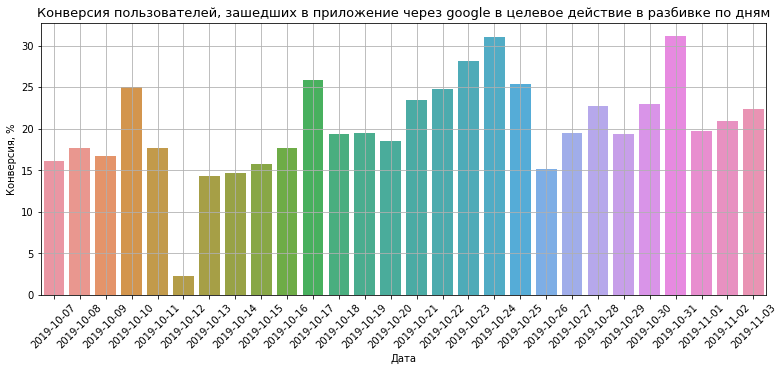

In [56]:
plt.figure(figsize=(13, 5))
plt.title('Конверсия пользователей, зашедших в приложение через google в целевое действие в разбивке по дням', fontsize=13)
sns.barplot(x=conv_google['event_date'], y=conv_google['conversion, %'])
plt.xlabel('Дата')
plt.xticks(rotation=45) 
plt.ylabel('Конверсия, %')
plt.grid(True);

In [57]:
print('Для пользователей, зашедших в приложение через google минимальная конверсия', conv_google['conversion, %'].min().round(1), '%')
print('Для пользователей, зашедших в приложение через google максимальная конверсия', conv_google['conversion, %'].max().round(1), '%')
print('Для пользователей, зашедших в приложение через google медианная конверсия', conv_google['conversion, %'].median().round(1), '%')
print('Для пользователей, зашедших в приложение через google средняя конверсия', conv_google['conversion, %'].mean().round(1), '%')

Для пользователей, зашедших в приложение через google минимальная конверсия 2.3 %
Для пользователей, зашедших в приложение через google максимальная конверсия 31.2 %
Для пользователей, зашедших в приложение через google медианная конверсия 19.5 %
Для пользователей, зашедших в приложение через google средняя конверсия 20.3 %


11 октября 2019 года конверсия пользователей, установивших приложение через google, была аномально малой - 2.3%, хотя во все остальные дни конверсия была больше 10%. Это может быть связано с проблемами в настройке рекламы или сбоями в гугле в целом. С 22 по 24 октября конверсия была максимальной - больше 25%.

In [58]:
conv__yandex_1 = df_source.query('(event_name == "show_contacts") & (source == "yandex")').groupby('event_date')['user_id'].nunique()
conv_yandex = df_source.query('source == "yandex"').groupby('event_date')['user_id'].nunique().reset_index()
conv_yandex = conv_yandex.merge(conv__yandex_1, on='event_date', how='left')

conv_yandex['conversion, %'] = (conv_yandex['user_id_y'] / conv_yandex['user_id_x'] *100).round(2)

conv_yandex

,event_date,user_id_x,user_id_y,"conversion, %"
0,2019-10-07,90,18,20.00
1,2019-10-08,92,19,20.65
2,2019-10-09,105,22,20.95
3,2019-10-10,109,20,18.35
4,2019-10-11,108,20,18.52
5,2019-10-12,86,19,22.09
6,2019-10-13,119,21,17.65
7,2019-10-14,140,29,20.71
8,2019-10-15,143,29,20.28
9,2019-10-16,115,19,16.52


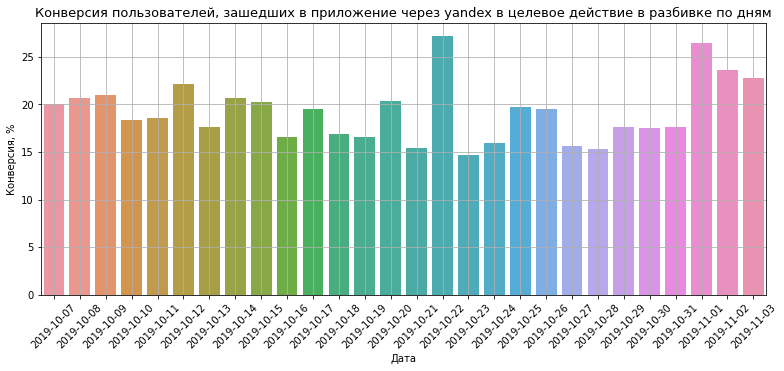

In [59]:
plt.figure(figsize=(13, 5))
plt.title('Конверсия пользователей, зашедших в приложение через yandex в целевое действие в разбивке по дням', fontsize=13)
sns.barplot(x=conv_yandex['event_date'], y=conv_yandex['conversion, %'])
plt.xlabel('Дата')
plt.xticks(rotation=45) 
plt.ylabel('Конверсия, %')
plt.grid(True);

In [60]:
print('Для пользователей, зашедших в приложение через yandex минимальная конверсия', conv_yandex['conversion, %'].min().round(1), '%')
print('Для пользователей, зашедших в приложение через yandex максимальная конверсия', conv_yandex['conversion, %'].max().round(1), '%')
print('Для пользователей, зашедших в приложение через yandex медианная конверсия', conv_yandex['conversion, %'].median().round(1), '%')
print('Для пользователей, зашедших в приложение через yandex средняя конверсия', conv_yandex['conversion, %'].mean().round(1), '%')

Для пользователей, зашедших в приложение через yandex минимальная конверсия 14.7 %
Для пользователей, зашедших в приложение через yandex максимальная конверсия 27.2 %
Для пользователей, зашедших в приложение через yandex медианная конверсия 19.0 %
Для пользователей, зашедших в приложение через yandex средняя конверсия 19.2 %


In [61]:
conv__other_1 = df_source.query('(event_name == "show_contacts") & (source == "other")').groupby('event_date')['user_id'].nunique()
conv_other = df_source.query('source == "other"').groupby('event_date')['user_id'].nunique().reset_index()
conv_other = conv_other.merge(conv__other_1, on='event_date', how='left')

conv_other['conversion, %'] = (conv_other['user_id_y'] / conv_other['user_id_x'] *100).round(2)

conv_other

,event_date,user_id_x,user_id_y,"conversion, %"
0,2019-10-07,58,7,12.07
1,2019-10-08,61,8,13.11
2,2019-10-09,62,9,14.52
3,2019-10-10,76,12,15.79
4,2019-10-11,47,5,10.64
5,2019-10-12,48,7,14.58
6,2019-10-13,58,6,10.34
7,2019-10-14,90,11,12.22
8,2019-10-15,90,17,18.89
9,2019-10-16,84,8,9.52


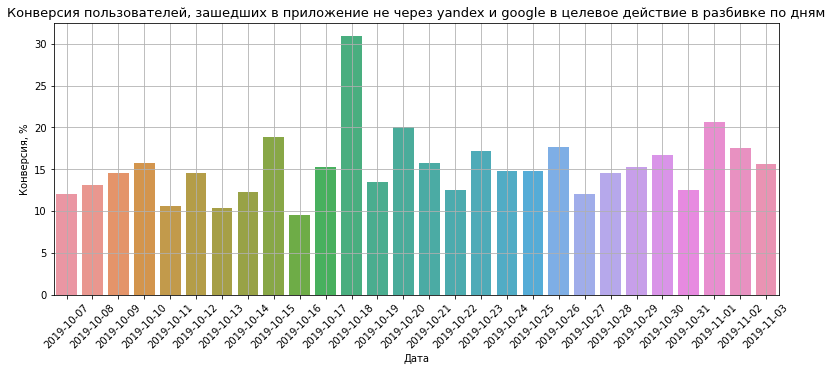

In [62]:
plt.figure(figsize=(13, 5))
plt.title('Конверсия пользователей, зашедших в приложение не через yandex и google в целевое действие в разбивке по дням', fontsize=13)
sns.barplot(x=conv_other['event_date'], y=conv_other['conversion, %'])
plt.xlabel('Дата')
plt.xticks(rotation=45) 
plt.ylabel('Конверсия, %')
plt.grid(True);

In [63]:
print('Для пользователей, зашедших в приложение не через google или yandex минимальная конверсия', conv_other['conversion, %'].min().round(1), '%')
print('Для пользователей, зашедших в приложение не через google или yandex максимальная конверсия', conv_other['conversion, %'].max().round(1), '%')
print('Для пользователей, зашедших в приложение не через google или yandex медианная конверсия', conv_other['conversion, %'].median().round(1), '%')
print('Для пользователей, зашедших в приложение не через google или yandex средняя конверсия', conv_other['conversion, %'].mean().round(1), '%')

Для пользователей, зашедших в приложение не через google или yandex минимальная конверсия 9.5 %
Для пользователей, зашедших в приложение не через google или yandex максимальная конверсия 31.0 %
Для пользователей, зашедших в приложение не через google или yandex медианная конверсия 14.8 %
Для пользователей, зашедших в приложение не через google или yandex средняя конверсия 15.3 %


В целом конверсия пользователей, установивших приложение через гугл или яндекс, больше конверсии через другие браузеры. 



При анализе общего поведения пользователей наблюдается некоторая цикличность в метриках по дням.

Вывод по шагу 2. Для выявления общего поведения пользователей определили следующие метрики: Retention rate, время, проведенное в приложении, частота, конверсия. 
    
    1. Удержание. Тенденция такова, что на второй день больше чем в остальные дни, с 3 по 10ые дни удержание колеблется, но в целом к 10му дню уменьшается. Общий характер поведения для разных источников одинаков.
    2. Среднее время сессии 12 мин 52 секунды, медианное 5 мин 35 секунд, максимальное 5 часов 21 минут 58 секунд. Сессии длительностью больше 2500 секунд - выбросы. Из 10368 сессий 2088 сессий являются нулевыми. Рекомендация: попробовать улучшить дизайн карточек объявлений для большего привлечения внимания пользователей.
    3. Среднее количество событий в день 2649, медианное 2725. Наблюдается некоторая цикличность в количестве событий, скорее всего, связанная с днями недели (люди активнее заходят в приложение в будние).
    4. Средняя конверсия - 18.3% в день, минимальная - 14.7%, максимальная - 22.6%. Конверсия в разбивке по источникам. 
    4.1. 11 ноября 2019 года конверсия пользователей, установивших приложение через google, была аномально малой - 2.3%, хотя во все остальные дни конверсия была больше 10%. Это может быть связано с проблемами в настройке рекламы или сбоями в гугле в целом. С 22 по 24 октября конверсия была максимальной - больше 25%.

    4.2 Для пользователей, зашедших в приложение через yandex минимальная конверсия 14.7 %, максимальная 27.2%, средняя 19.2%. 

    4.3 Для пользователей, зашедших в приложение не через google или yandex минимальная конверсия 9.5 %, максимальная 31.0%, средняя 15.3%. В целом конверсия пользователей, установивших приложение через гугл или яндекс, больше конверсии через другие браузеры.


# Шаг 3. Сегментация данных по длительности сессий.

Посмотрим на минимальную, максимальную, среднюю и медианную длительности сессий.

Нам нужно разделить пользователей на несколько групп, которые будут между собой различаться по общему характеру поведения для того, чтобы в дальнейшем попытаться скорректировать их действия в сторону увеличения числа покупок через приложение. Одним из таких признаков может являться длительность сессии, так как длительность сессии показывает заинтересованность пользователя в совершении покупки. Проанализировав коэффициент удержания и конверсию, мы сможем проверить эту гипотезу.

In [64]:
session_dur

,session_id,event_time
0,1,595.727258
1,2,507.385985
2,3,899.272096
3,4,758.171767
4,5,1520.787329
...,...,...
10363,10364,0.000000
10364,10365,974.291817
10365,10366,296.677281
10366,10367,948.307055


In [65]:
df_source_1 = df_source.merge(session_dur, on='session_id', how='left')
df_source_1 = df_source_1.rename(columns = {'event_time_y': 'duration'})
df_source_1

,event_time_x,event_name,user_id,session_id,event_date,first_day,source,lifetime,duration
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258
...,...,...,...,...,...,...,...,...,...
74192,2019-11-03 15:51:23.959572,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368,2019-11-03,2019-10-12,google,22,1944.381272
74193,2019-11-03 15:51:57.899997,show_contacts,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368,2019-11-03,2019-10-12,google,22,1944.381272
74194,2019-11-03 16:07:40.932077,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368,2019-11-03,2019-10-12,google,22,1944.381272
74195,2019-11-03 16:08:18.202734,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368,2019-11-03,2019-10-12,google,22,1944.381272


In [66]:
df_source_1['duration']

0         595.727258
1         595.727258
2         595.727258
3         595.727258
4         595.727258
            ...     
74192    1944.381272
74193    1944.381272
74194    1944.381272
74195    1944.381272
74196    1944.381272
Name: duration, Length: 74197, dtype: float64

In [67]:
df_source_1 = df_source_1.merge(df_source_1.groupby('user_id')['duration'].mean(), on='user_id', how='left')

In [68]:
df_source_1 = df_source_1.rename(columns = {'duration_y': 'mean_duration'})
df_source_1.head()


,event_time_x,event_name,user_id,session_id,event_date,first_day,source,lifetime,duration_x,mean_duration
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258,744.179221
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258,744.179221
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258,744.179221
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258,744.179221
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258,744.179221


In [69]:
df_source_1['duration_x'].describe()

count    74197.000000
mean      1957.649496
std       2261.389204
min          0.000000
25%        496.438944
50%       1266.670072
75%       2570.646904
max      19318.296302
Name: duration_x, dtype: float64

Минимальная длительность сессии 0 секунд, максимальная -19318, медианная - 1267, средняя - 1957. Разобьем все данные на 4 группы по средней длительности сессии для каждого пользователя по квартилям.  

In [70]:
df_source_1['cat'] = pd.qcut(df_source_1['mean_duration'], q=4)


In [71]:
df_source_1['cat'].unique()

[(695.24, 1412.771], (2667.614, 18902.924], (1412.771, 2667.614], (-0.001, 695.24]]
Categories (4, interval[float64]): [(-0.001, 695.24] < (695.24, 1412.771] < (1412.771, 2667.614] < (2667.614, 18902.924]]

In [72]:
df_source_1['cat'] = df_source_1['cat'].astype('str')
df_source_1.head()

,event_time_x,event_name,user_id,session_id,event_date,first_day,source,lifetime,duration_x,mean_duration,cat
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258,744.179221,"(695.24, 1412.771]"
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258,744.179221,"(695.24, 1412.771]"
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258,744.179221,"(695.24, 1412.771]"
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258,744.179221,"(695.24, 1412.771]"
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258,744.179221,"(695.24, 1412.771]"


In [73]:
df_source_1['cat'].unique()

array(['(695.24, 1412.771]', '(2667.614, 18902.924]',
       '(1412.771, 2667.614]', '(-0.001, 695.24]'], dtype=object)

In [74]:

# составляем таблицу удержания
retention_history = df_source_1.pivot_table(
     index=['first_day', 'cat'], columns='lifetime', values='user_id', aggfunc='nunique'
        )
cohort_sizes = df_source_1.pivot_table(
     index=['first_day', 'cat'], values='user_id', aggfunc='nunique'
        ).rename(columns={'user_id': 'cohort_size'})

# ограничиваем данные по горизонту дней = 10
last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
retention = retention_history.query('first_day <= @last_suitable_acquisition_date')

columns_mask = retention.columns < horizon_days 
valid_columns = retention.columns[columns_mask]

retention_valid = retention[valid_columns]

# рассчитываем коэф удержания
for lifetime in retention_valid.columns:
    retention_valid[lifetime] = retention_valid[lifetime] / cohort_sizes['cohort_size']

# пропуски заполняем нулями
retention_valid = retention_valid.fillna(0)

retention_valid

lifetime                            0         1         2         3         4  \
first_day  cat                                                                  
2019-10-07 (-0.001, 695.24]       1.0  0.147059  0.068627  0.127451  0.068627   
           (1412.771, 2667.614]   1.0  0.250000  0.125000  0.156250  0.062500   
           (2667.614, 18902.924]  1.0  0.333333  0.166667  0.083333  0.125000   
           (695.24, 1412.771]     1.0  0.130435  0.130435  0.043478  0.043478   
2019-10-08 (-0.001, 695.24]       1.0  0.182927  0.134146  0.109756  0.048780   
...                               ...       ...       ...       ...       ...   
2019-10-24 (695.24, 1412.771]     1.0  0.142857  0.071429  0.071429  0.000000   
2019-10-25 (-0.001, 695.24]       1.0  0.073171  0.048780  0.109756  0.109756   
           (1412.771, 2667.614]   1.0  0.130435  0.043478  0.043478  0.043478   
           (2667.614, 18902.924]  1.0  0.200000  0.200000  0.500000  0.200000   
           (695.24, 1412.771]     1.0  0.156250  0.093750  0.125000  0.125000   

lifetime                                 5         6         7         8  \
first_day  cat                                                             
2019-10-07 (-0.001, 695.24]       0.049020  0.029412  0.049020  0.049020   
           (1412.771, 2667.614]   0.031250  0.031250  0.031250  0.062500   
           (2667.614, 18902.924]  0.041667  0.041667  0.166667  0.083333   
           (695.24, 1412.771]     0.108696  0.065217  0.130435  0.086957   
2019-10-08 (-0.001, 695.24]       0.036585  0.085366  0.048780  0.048780   
...                                    ...       ...       ...       ...   
2019-10-24 (695.24, 1412.771]     0.035714  0.071429  0.000000  0.000000   
2019-10-25 (-0.001, 695.24]       0.060976  0.036585  0.060976  0.048780   
           (1412.771, 2667.614]   0.043478  0.086957  0.043478  0.043478   
           (2667.614, 18902.924]  0.000000  0.200000  0.200000  0.000000   
           (695.24, 1412.771]     0.093750  0.062500  0.125000  0.031250   

lifetime                                 9  
first_day  cat                              
2019-10-07 (-0.001, 695.24]       0.029412  
           (1412.771, 2667.614]   0.062500  
           (2667.614, 18902.924]  0.041667  
           (695.24, 1412.771]     0.086957  
2019-10-08 (-0.001, 695.24]       0.048780  
...                                    ...  
2019-10-24 (695.24, 1412.771]     0.035714  
2019-10-25 (-0.001, 695.24]       0.048780  
           (1412.771, 2667.614]   0.043478  
           (2667.614, 18902.924]  0.000000  
           (695.24, 1412.771]     0.093750  

[76 rows x 10 columns]

Text(95.99999999999999, 0.5, 'Первый день использования приложения')

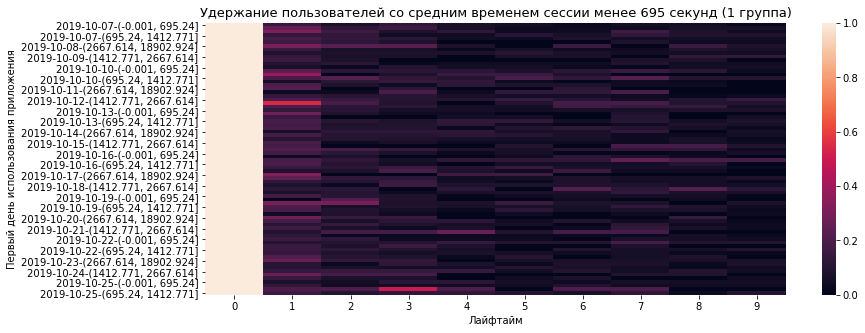

In [75]:

plt.figure(figsize=(13, 5))
plt.title('Удержание пользователей со средним временем сессии менее 695 секунд (1 группа)', fontsize=13)
sns.heatmap(retention_valid);
plt.xlabel('Лайфтайм')
plt.ylabel('Первый день использования приложения')

Тепловую карту построили для категории пользователей, длительность сессий которых меньше 695 секунд. Удержание после первого дня в целом максимально во второй день.со 2 по 10 дни удержание колеблется.

In [76]:
data = pd.DataFrame()
i = 0
for first_day, cat in retention_valid.index:
    for lifetime in retention_valid.columns:
        data.loc[i, 'first_day'] = first_day
        data.loc[i, 'cat'] = cat
        data.loc[i, 'lifetime'] = lifetime
        data.loc[i, 'retention'] = retention_valid.loc[(first_day, cat), lifetime]
        i += 1

data.head()

,first_day,cat,lifetime,retention
0,2019-10-07,"(-0.001, 695.24]",0.0,1.000000
1,2019-10-07,"(-0.001, 695.24]",1.0,0.147059
2,2019-10-07,"(-0.001, 695.24]",2.0,0.068627
3,2019-10-07,"(-0.001, 695.24]",3.0,0.127451
4,2019-10-07,"(-0.001, 695.24]",4.0,0.068627


Text(0, 0.5, 'Retention rate')

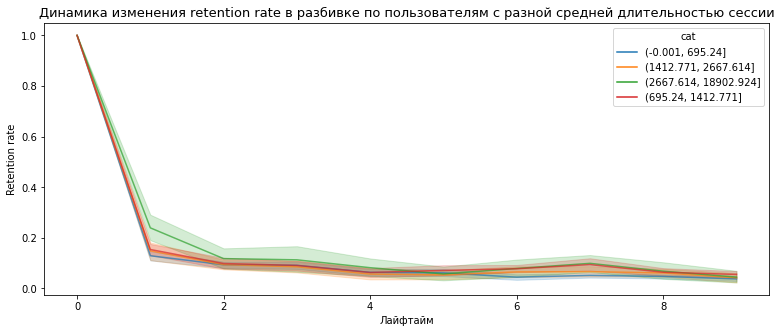

In [77]:
plt.figure(figsize=(13, 5))
plt.title('Динамика изменения retention rate в разбивке по пользователям с разной средней длительностью сессии', fontsize=13)
sns.lineplot(data=data, x='lifetime', y='retention', hue='cat', alpha=0.7);
plt.xlabel('Лайфтайм')
plt.ylabel('Retention rate')

В целом удержание пользователей в сегментации по длительности использования приложения имеет одинаковую тенденцию. во второй день удержание чуть больше чем в остальные дни, затем колеблется, к 10 дню минимально.

2. Конверсия в целевое действие.

Минимальная конверсия для (695.24, 1412.771] 7.53 %
Максимальная конверсия для (695.24, 1412.771] 27.87 %
Медианная конверсия для (695.24, 1412.771] 14.92 %
Средняя конверсия для (695.24, 1412.771] 14.885357142857144 %
Минимальная конверсия для (2667.614, 18902.924] 11.11 %
Максимальная конверсия для (2667.614, 18902.924] 41.67 %
Медианная конверсия для (2667.614, 18902.924] 26.255000000000003 %
Средняя конверсия для (2667.614, 18902.924] 26.148571428571433 %
Минимальная конверсия для (1412.771, 2667.614] 6.06 %
Максимальная конверсия для (1412.771, 2667.614] 30.14 %
Медианная конверсия для (1412.771, 2667.614] 17.884999999999998 %
Средняя конверсия для (1412.771, 2667.614] 18.21535714285714 %
Минимальная конверсия для (-0.001, 695.24] 4.85 %
Максимальная конверсия для (-0.001, 695.24] 20.0 %
Медианная конверсия для (-0.001, 695.24] 14.395 %
Средняя конверсия для (-0.001, 695.24] 13.665000000000003 %


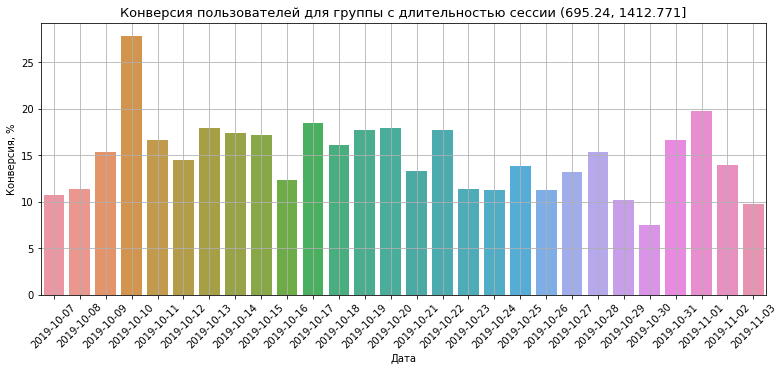

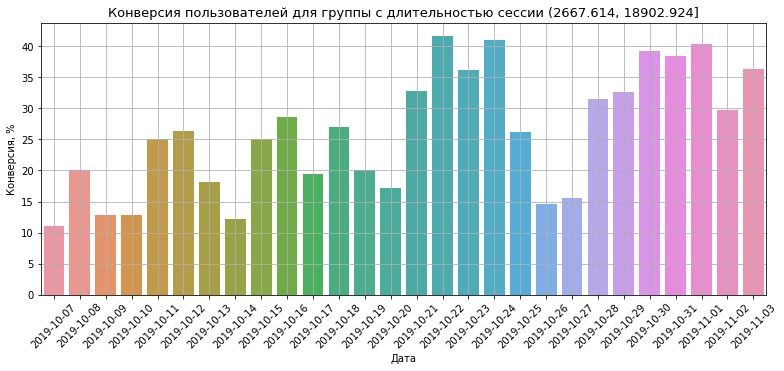

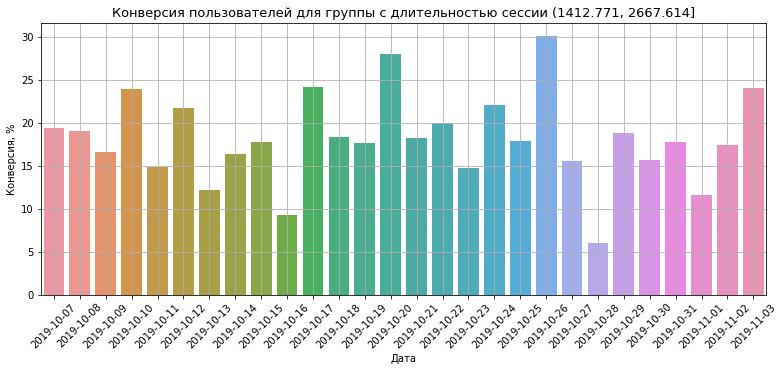

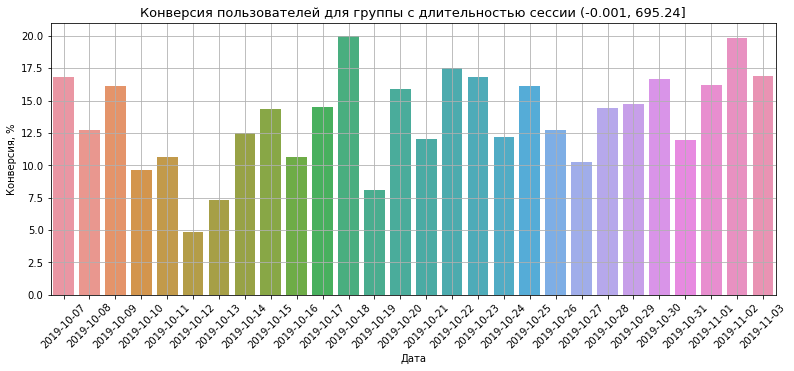

In [78]:
for element in df_source_1['cat'].unique():
    conv_1 = df_source_1.query('(event_name == "show_contacts") & (cat == @element)').groupby('event_date')['session_id'].nunique()
    conv = df_source_1.query('cat == @element').groupby('event_date')['session_id'].nunique().reset_index()
    conv = conv.merge(conv_1, on='event_date', how='left')

    conv['conversion, %'] = (conv['session_id_y'] / conv['session_id_x'] *100).round(2)

    print('Минимальная конверсия для {}'.format(element), conv['conversion, %'].min(), '%')
    print('Максимальная конверсия для {}'.format(element), conv['conversion, %'].max(), '%')
    print('Медианная конверсия для {}'.format(element), conv['conversion, %'].median(), '%')
    print('Средняя конверсия для {}'.format(element), conv['conversion, %'].mean(), '%')
    plt.figure(figsize=(13, 5))
    plt.title('Конверсия пользователей для группы с длительностью сессии {}'.format(element), fontsize=13)
    sns.barplot(x=conv['event_date'], y=conv['conversion, %'])
    plt.xlabel('Дата')
    plt.xticks(rotation=45) 
    plt.ylabel('Конверсия, %')
    plt.grid(True);

0 группа - сессии длительностью (-0.001, 695.24]

1 группа - сессии длительность (695.24, 1412.771] 

2 группа - сессии длительностью (1412.771, 2667.614]

3 группа - сессии длительностью (2667.614, 18902.924].
Тенденция такова, что чем дольше в среднем длится сессия пользователя, тем больше конверсия. Конверсия меньше всего в 0 группе (медианное значение 14.395%), в 1 группе медиана - 14.92%, во 2 - 17.88%, в 3 - 26.25%.

# Шаг 4. Проверка гипотез.

Гипотеза 1: Пользователи, которые установили приложение по ссылке из яндекса и которые установили приложение по ссылке из гугла демонстрируют разную конверсию в просмотры контактов.

Н0: Конверсия в просмотры контактов группы пользователей, которые установили приложение по ссылке из гугла = конверсии в просмотры контактов группы пользователей, которые установили приложение по ссылке из яндекса.

Н1: Конверсия в просмотры контактов группы пользователей, которые установили приложение по ссылке из гугла != конверсии в просмотры контактов группы пользователей, которые установили приложение по ссылке из яндекса.

alpha = 0.05

In [79]:
def z_test(successes1, successes2, trials1, trials2, alpha=0.05):
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    
    print(successes1, successes2, trials1, trials2)

    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)

    if (p_value < alpha):
        display('Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия')
    else:
        display('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет')

In [80]:
df_source.head()

,event_time,event_name,user_id,session_id,event_date,first_day,source,lifetime
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0


In [81]:
tr_1 =df_source.query('source == "yandex"')['user_id'].nunique()
tr_1

1934

In [82]:
tr_2 =df_source.query('source == "google"')['user_id'].nunique()
tr_2

1129

In [83]:
s_1 =df_source.query('source == "yandex" & event_name =="show_contacts"')['user_id'].nunique()
s_1

478

In [84]:
s_2 =df_source.query('source == "google" & event_name =="show_contacts"')['user_id'].nunique()
s_2

275

In [85]:
z_test(s_1, s_2, tr_1, tr_2)

478 275 1934 1129
p-значение:  0.8244316027993777


'Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет'

В результате проверки гипотезы не получилось отвергнуть нулевую гипотезу о том, что Конверсия в просмотры контактов группы пользователей, которые установили приложение по ссылке из гугла = конверсии в просмотры контактов группы пользователей, которые установили приложение по ссылке из яндекса. С большой долей вероятности конверсии через гугл и яндекс не имеют статистически значимых отличий.

Гипотеза 2. Пользователи, средняя длительность сессии которых 0 - 695 секунд демонстрируют разную конверсию с пользователями, средняя длительность сессии которых 695 - 1412 секунд.

Н0: Конверсия пользователей, средняя длительность сессии которых 0 - 695 секунд = конверсия пользователей, средняя длительность сессии которых 695 - 1412 секунд.

Н1: Конверсия пользователей, средняя длительность сессии которых 0 - 695 секунд != конверсия пользователей, средняя длительность сессии которых 695 - 1412 секунд.
alpha = 0.05

In [89]:
df_source_1.head()

,event_time_x,event_name,user_id,session_id,event_date,first_day,source,lifetime,duration_x,mean_duration,cat
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258,744.179221,"(695.24, 1412.771]"
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258,744.179221,"(695.24, 1412.771]"
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258,744.179221,"(695.24, 1412.771]"
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258,744.179221,"(695.24, 1412.771]"
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07,2019-10-07,other,0,595.727258,744.179221,"(695.24, 1412.771]"


In [90]:
df_source_1['cat'].unique()

array(['(695.24, 1412.771]', '(2667.614, 18902.924]',
       '(1412.771, 2667.614]', '(-0.001, 695.24]'], dtype=object)

In [91]:
tr_1_2 =df_source_1.query('cat == "(-0.001, 695.24]"')['user_id'].nunique()
tr_1_2

2217

In [92]:
tr_2_2 =df_source_1.query('cat == "(695.24, 1412.771]"')['user_id'].nunique()
tr_2_2

1049

In [93]:
s_1_2 = df_source_1.query('cat == "(-0.001, 695.24]" & event_name == "show_contacts"')['user_id'].nunique()
s_1_2

439

In [94]:
s_2_2 = df_source_1.query('cat == "(695.24, 1412.771]" & event_name == "show_contacts"')['user_id'].nunique()
s_2_2

241

In [95]:
z_test(s_1_2, s_2_2, tr_1_2, tr_2_2)

439 241 2217 1049
p-значение:  0.03705331328975947


'Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия'

В результате проверки отвергаем нулевую гипотезу о том, что Конверсия пользователей, средняя длительность сессии которых 0 - 695 секунд = конверсия пользователей, средняя длительность сессии которых 695 - 1412 секунд. Эти две группы пользователей демонстрируют разную конверсию.

# Шаг 5. Общий вывод. 

1. На первом шаге посмотрели на общую информацию о данных. 

Данные приведены за период 7 октября 2019 года по 3 ноября 2019 года. 

В датасете mobile_dataset столбец event_time приведен к типу данных dataframe, остальные столбцы оставили типа object. 

Привели названия столбцов к стандартному виду. 

Пропусков не обнаружено, явных дубликатов нет. Неявные дубликаты: в столбце 'event_name'    'contacts_show' и 'show_contacts' обозначают одно событие - пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления. Объединили эти названия. 

2. На втором шаге провели исследовательский анализ данных. 

Выделили сессии пользователей, считая, что сессия пользователя закончилась, если между соседними действиями прошло больше 30 минут. Всего получилось 10368 сессий.

Определили следующие метрики: Retention rate, Время, проведенное в приложении, Частота, Конверсия. 

2.1 Retention rate. Задали горизонт анализа 10 дней. Общая тенденция такова, что удержание пользователей на второй день больше чем в остальные дни, с 3 по 10ые дни удержание колеблется, но в целом к 10му дню уменьшается. Построили графики среднего retention rate по источникам. Тенденция в разбивке по разным источников такая же. По графикам видно, что удержание со второго и все последующие дни меньше 0.2.

2.2 Время, проведенное в приложении. Медианное время, проведенное пользователями в приложении 5 мин 35 секунд. Среднее время, проведенное пользователями в приложении 12 минут 52 секунды. Максимальное 5 часов 21 минут 58 секунд. Сессии длительностью больше 2500 секунд - выбросы.

2.3 Частота (количество всех событий в разбивке по дням). Среднее количество событий в день 2649, медианное 2725. Наблюдается некоторая цикличность в количестве событий, скорее всего, связанная с днями недели (люди активнее заходят в приложение в будние).

2.4 Конверсия в целевое действие show_contacts. Средняя конверсия - 18.3% в день, минимальная - 14.7%, максимальная - 22.6%. Теперь рассмотрим конверсию в разбивке по источникам.

Для пользователей, зашедших в приложение через google минимальная конверсия 2.3 %
Для пользователей, зашедших в приложение через google максимальная конверсия 31.2 %
Для пользователей, зашедших в приложение через google медианная конверсия 19.5 %
Для пользователей, зашедших в приложение через google средняя конверсия 20.3 %
11 ноября 2019 года конверсия пользователей, установивших приложение через google, была аномально малой - 2.3%, хотя во все остальные дни конверсия была больше 10%. Это может быть связано с проблемами в настройке рекламы или сбоями в гугле в целом. С 22 по 24 октября конверсия была максимальной - больше 25%.

Для пользователей, зашедших в приложение через yandex минимальная конверсия 14.7 %
Для пользователей, зашедших в приложение через yandex максимальная конверсия 27.2 %
Для пользователей, зашедших в приложение через yandex медианная конверсия 19.0 %
Для пользователей, зашедших в приложение через yandex средняя конверсия 19.2 %

Для пользователей, зашедших в приложение не через google или yandex минимальная конверсия 9.5 %
Для пользователей, зашедших в приложение не через google или yandex максимальная конверсия 31.0 %
Для пользователей, зашедших в приложение не через google или yandex медианная конверсия 14.8 %
Для пользователей, зашедших в приложение не через google или yandex средняя конверсия 15.3 %
В целом конверсия пользователей, установивших приложение через гугл или яндекс, больше конверсии через другие браузеры.



При анализе общего поведения пользователей наблюдается некоторая цикличность в метриках по дням.

3. Сегментация данных по длительности сессий.

Минимальная длительность сессии 0 секунд, максимальная -19318, медианная - 1267, средняя - 1957. Разбили все данные на 4 группы по средней длительности сессии для каждого пользователя по квартилям. 0 группа - сессии длительностью (-0.001, 695.24]

1 группа - сессии длительность (695.24, 1412.771]

2 группа - сессии длительностью (1412.771, 2667.614]

3 группа - сессии длительностью (2667.614, 18902.924]. Посчитали retention rate и конверсию.

3.1 Retention rate. В целом удержание пользователей в сегментации по длительности использования приложения имеет одинаковую тенденцию. во второй день удержание чуть больше чем в остальные дни, затем колеблется, к 10 дню минимально. Удержание со второго и все  последующие дни - менее 0.2.

3.2. Конверсия. Тенденция такова, что чем дольше в среднем длится сессия пользователя, тем больше конверсия. Конверсия меньше всего в 0 группе (медианное значение 14.4%), в 1 группе медиана - 14.9%, во 2 - 17.8%, в 3 - 26.3%.

4. Проверка гипотез. Были выдвинуты 2 гипотезы.

Гипотеза 1: Пользователи, которые установили приложение по ссылке из яндекса и которые установили приложение по ссылке из гугла демонстрируют разную конверсию в просмотры контактов.

Н0: Конверсия в просмотры контактов группы пользователей, которые установили приложение по ссылке из гугла = конверсии в просмотры контактов группы пользователей, которые установили приложение по ссылке из яндекса.

Н1: Конверсия в просмотры контактов группы пользователей, которые установили приложение по ссылке из гугла != конверсии в просмотры контактов группы пользователей, которые установили приложение по ссылке из яндекса.

alpha = 0.05

В результате проверки гипотезы не получилось отвергнуть нулевую гипотезу о том, что Конверсия в просмотры контактов группы пользователей, которые установили приложение по ссылке из гугла = конверсии в просмотры контактов группы пользователей, которые установили приложение по ссылке из яндекса. С большой долей вероятности конверсии через гугл и яндекс не имеют статистически значимых отличий.

Гипотеза 2. Пользователи, средняя длительность сессии которых 0 - 695 секунд демонстрируют разную конверсию с пользователями, средняя длительность сессии которых 695 - 1412 секунд.

Н0: Конверсия пользователей, средняя длительность сессии которых 0 - 695 секунд = конверсия пользователей, средняя длительность сессии которых 695 - 1412 секунд.

Н1: Конверсия пользователей, средняя длительность сессии которых 0 - 695 секунд != конверсия пользователей, средняя длительность сессии которых 695 - 1412 секунд. alpha = 0.05

В результате проверки отвергаем нулевую гипотезу о том, что Конверсия пользователей, средняя длительность сессии которых 0 - 695 секунд = конверсия пользователей, средняя длительность сессии которых 695 - 1412 секунд. Эти две группы пользователей демонстрируют разную конверсию.

Рекомендации. Чем больше времени проводит пользователь в приложении, тем выше конверсия. Удержание к 10 дню уменьшается. Поэтому стоит придумать способы вовлечения пользователя в приложении. Например, присылать пуш-уведомления с интересующими пользователя товарами или персональными акциями, чтобы пользователь не забывал о приложении. Также можно поэкспериментировать со стилистикой объявлений, чтобы больше заинтересовать пользователя. Разницы между конверсией пользователей, пришедших из гугла и из яндекса нет, поэтому, скорее всего, не имеет смысла использовать разные варианты привлечения для разных браузров.